### 이미지처리 과제 #02

In [1]:
# %pip install pytesseract
%pip install opencv-python==4.5.5.64

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

#### 01_ 차량 이미지 파일 읽기

이미지 크기 >>  983 1700


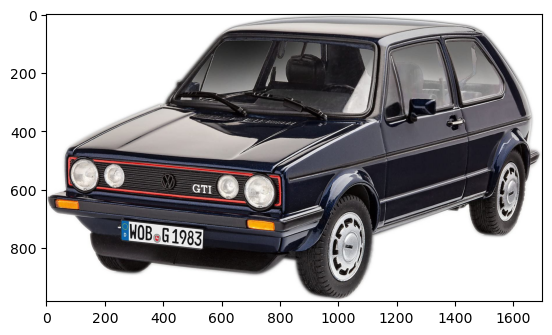

In [3]:
image_path = '../02_차번호판/src/car.jpg'
image = cv2.imread(image_path)

car_org = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

car_h, car_w, car_c = car_org.shape
print('이미지 크기 >> ', car_h, car_w)

plt.imshow(car_org)
plt.show()

#### 02_GrayScale 변환

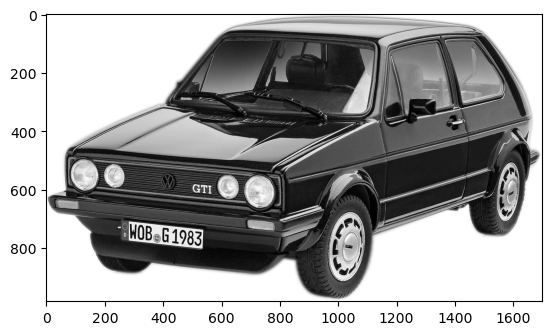

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, 'gray')
plt.show()

#### 03_콘트라스트 최대화

[[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]]


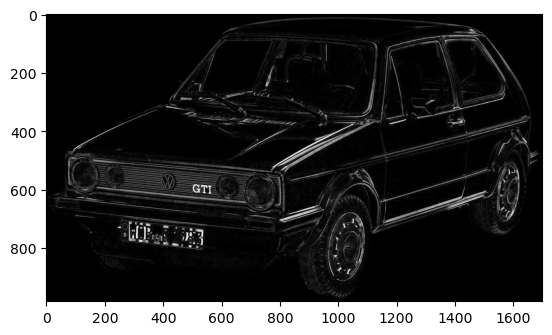

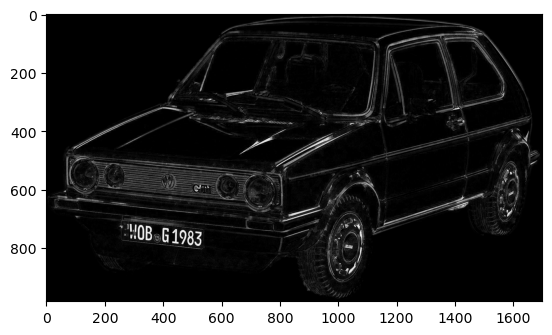

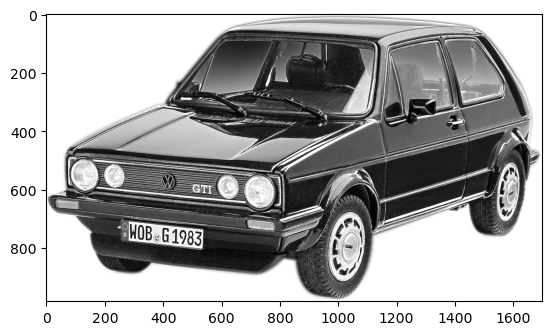

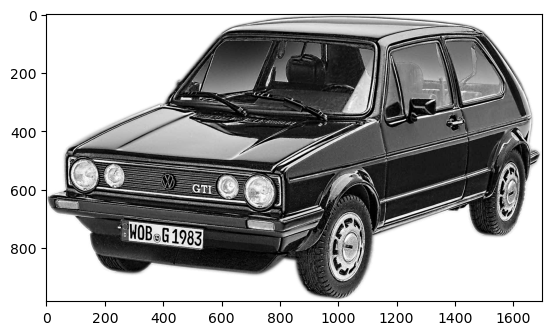

In [5]:
structureElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
print(structureElement)

imgTopHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structureElement)
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structureElement)

imgGrayScalePlusTopHat = cv2.add(gray_image, imgTopHat)
imgGrayScaleMinusTopHat = cv2.subtract(imgGrayScalePlusTopHat, imgBlackHat)

plt.imshow(imgTopHat, 'gray')
plt.show()
plt.imshow(imgBlackHat, 'gray')
plt.show()
plt.imshow(imgGrayScalePlusTopHat, 'gray')
plt.show()
plt.imshow(imgGrayScaleMinusTopHat, 'gray')
plt.show()

#### 04_이진화

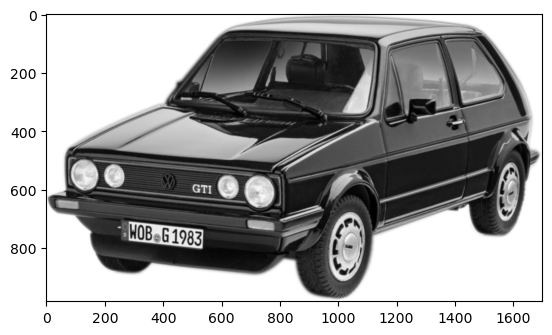

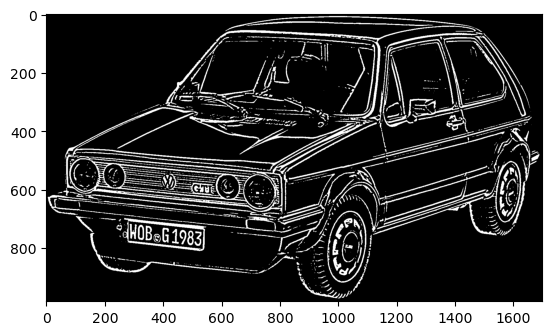

In [6]:
img_blurred = cv2.GaussianBlur(gray_image, ksize=(7,7), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue = 255.0,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize = 19,
    C = 9   # 상수(Constant) = 임계값

)

plt.imshow(img_blurred, 'gray')
plt.show()

plt.imshow(img_thresh, 'gray')
plt.show()

#### 05_외각선 검출

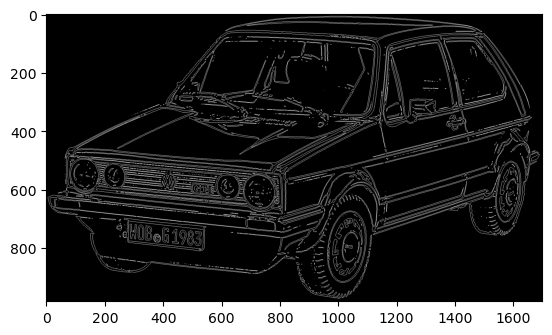

In [7]:
contours, hiearchy = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

contours_result = np.zeros((car_h,car_w,car_c), dtype=np.uint8)
# print(contours_result)

cv2.drawContours(contours_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.imshow(contours_result,'gray')
plt.show()

#### 06_바운딩 박스 박스 표시

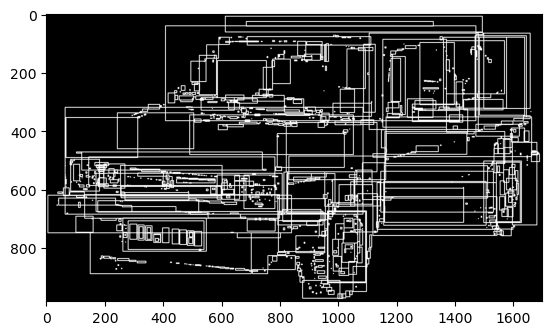

In [8]:
temp_result = np.zeros((car_h,car_w,car_c), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    # pt1 : 왼쪽 아래 / pt2 : 오른쪽 위
    # cx : center, h: middle height
    
    contours_dict.append({
        'contours':contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w/2),
        'cy': y + (h/2)
    })
    
plt.imshow(temp_result, 'gray')
plt.show()

#### 07_select Candidates by Char Size

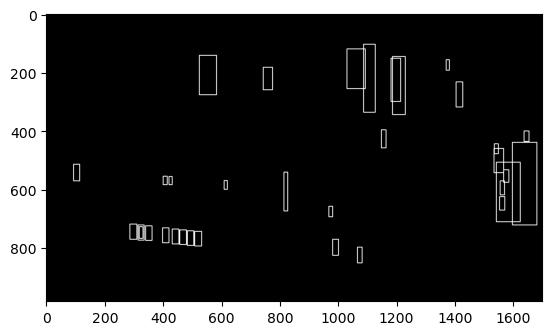

In [9]:
MIN_AREA = 100
MIN_WIDTH, MIN_HEIGHT = 10, 20
MIN_RATIO, MAX_RATIO = 0.05, 0.5

possible_contours = []

cnt = 0

for d in contours_dict:
    area = d['w'] * d['h']  # 면적
    ratio = d['w'] / d['h'] # 비율
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH \
    and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d) # possible_contours에 저장
        
possible_result = np.zeros((car_h,car_w,car_c), dtype=np.uint8) # nparray로 변환

for d in possible_contours:
    cv2.rectangle(possible_result, pt1=(d['x'],d['y']),pt2=(d['x'] + d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
    
plt.imshow(possible_result,'gray')
plt.show()

#### 08_Select Candiates by Arrangement of Contours

In [10]:
MAX_DIAG_MUTLIPLAYER = 3    # 윤곽선 사이 최대 대각선 차이
MAX_ANGLE_DIFF = 12.0       # 두 윤곽선 사이 각도 최대차이
MAX_AREA_DIFF = 0.5         # 두 윤곽선 사이의 최대 면적 차이
MAX_WIDTH_DIFF = 0.8        # 두 윤곽선 사이의 최대 너비 차이
MAX_HEIGHT_DIFF =0.2        # 두 윤곽선 사이의 최대 높이 차이
MIN_N_MATHED = 3            # 윤곽선의 최소 개수

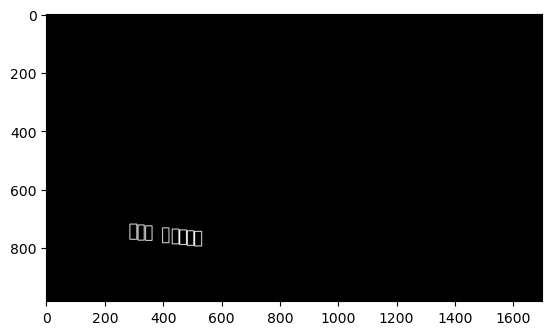

In [11]:
def find_chars(contour_list) :
    matched_result_idx = []
    
    for d1 in contour_list :
        matched_contours_idx = []
    
        for d2 in contour_list :
            if d1['idx'] == d2['idx']:
                continue
        
            # x,y의 중심 차이 절대값
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(
                                d1['w'] ** 2 + d1['h'] ** 2
                                ) # 대각선 길이
            
            distance =  np.linalg.norm(
                        np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])
                        )  # 두 좌표 사이의 거리
        
            if dx==0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))
                area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
                width_diff = abs(d1['w'] - d2['w']) / d1['w']
                height_diff = abs(d1['h'] - d2['h']) / d1['h']
                
            if distance < diagonal_length1 * MAX_DIAG_MUTLIPLAYER \
                and angle_diff < MAX_ANGLE_DIFF \
                and area_diff < MAX_AREA_DIFF \
                and width_diff < MAX_WIDTH_DIFF \
                and height_diff < MAX_HEIGHT_DIFF :
                    matched_contours_idx.append(d2['idx'])  # if에 만족하는 d2의 idx를 저장
        
        # append this contour
        matched_contours_idx.append(d1['idx'])  # 그리고 그에 맞는 d1의 idx도 저장
        
        if len(matched_contours_idx) < MIN_N_MATHED: # 최소 개수 만족 할때 까지 진행
            continue
        
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []  # 매칭이 안되는 contour 모음
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx :
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)  # 매칭되지 않는 객체 추출, 변수에 저장
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)  # 걸러낸 것들의 글자 찾기

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
                
        break
            
    return matched_result_idx
        
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
# Visualize possible contours
possible_result = np.zeros((car_h,car_w,car_c), dtype=np.uint8) # nparray로 변환

for r in matched_result:
    for d in r:
        cv2.rectangle(possible_result, pt1=(d['x'],d['y']),pt2=(d['x'] + d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
    
plt.imshow(possible_result,'gray')
plt.show()

#### 09_차량 번호판 이미지를 회전시키는 작업


In [12]:
PLATE_WIDTH_PADDING = 9.5   # 번호판 주변 여유공간
PLATE_HEIGHT_PADDING = 2.5
MIN_PLATE_RATIO = 2.5 # 가로세로 최소값 / 최대값
MAX_PLATE_RATIO = 3

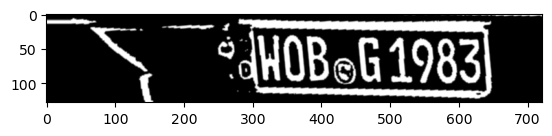

In [13]:
plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result) :
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    # lambda 함수를 사용하여 x 라는 변수를 입력으로 받고, 해당 변수의 'cx' 키에 대한 값을 반환하는 함수를 정의한 것이
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2
    # print(plate_cx,plate_cy)
    
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING 
    # sorted_chars 리스트에서 가장 오른쪽 요소와 가장 왼쪽 요소의 'x' 값과 너비('w')를 이용하여 번호판의 폭을 계산하는 부분입니다.
    
    sum_height = 0
    for d in sorted_chars :
        sum_height += d['h']
        
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    # 리스트에 있는 각 요소의 높이('h') 값을 모두 더한 후, 평균 높이를 계산하여 번호판의 높이를 결정하는 부분입니다.
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    # 리스트에서 가장 오른쪽 요소와 가장 왼쪽 요소의 중심점('cy') 값을 이용하여 삼각형의 높이를 계산하는 부분입니다.
    
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height/triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx,plate_cy), angle=angle, scale=1.3)
    # cv2.getRotationMatrix2D 함수는 중심점을 기준으로 이미지를 회전하기 위한 변환 행렬을 생성하는 함수입니다.

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(car_w, car_h))
    # cv2.warpAffine 함수는 이미지에 변환 행렬을 적용하여 이미지를 변환하는 함수입니다.

    img_cropped = cv2.getRectSubPix(
        # cv2.getRectSubPix() 함수는 지정한 영역을 잘라낸 결과 이미지를 반환합니다.
        img_rotated,
        patchSize = (int(plate_width), int(plate_height)),
        center = (int(plate_cx), int(plate_cy))
    )
    plate_imgs.append(img_cropped)

    plate_infos.append({
        'x' : int(plate_cx - plate_width/2),
        'y' : int(plate_cy - plate_height/2),
        'w' : int(plate_width),
        'h' : int(plate_height)
    })

plt.imshow(img_cropped, 'gray')
plt.show()

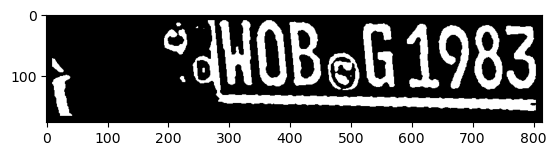

In [14]:
longest_idx, longest_text = -1,0
plate_chars = []

for i , plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0,0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0 , type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    contours, hiearchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    for contour in contours :
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h
        
        if area > MIN_AREA \
            and w > MIN_WIDTH \
            and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h
                    
img_result = plate_img[plate_min_y : plate_max_y, plate_min_x : plate_max_x]

img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
_, img_result = cv2.threshold(img_result,thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

img_result = cv2.copyMakeBorder(img_result,top=10, bottom=10, left=10, right=10,
                                borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
plt.imshow(img_result, 'gray')
plt.show()

# text = pytesseract.image_to_string(img_result)
# print(text)

{'x': -35, 'y': 683, 'w': 722, 'h': 128}


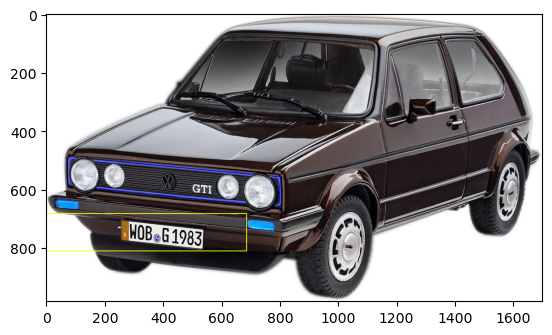

In [15]:
info = plate_infos[longest_idx]
img_out = image.copy()

print(info)

cv2.rectangle(img_out, (info['x'], info['y'],), (info['x'] + info['w'], info['y'] + info['h']), color=(255,255,0), thickness=2)

plt.imshow(img_out)
plt.show()